In [2]:
from torch.utils.data import DataLoader 
import torch
import matplotlib.pyplot as plt
from pyscf import gto, dft, scf 
from kspies import wy, zmp
from dpyscfl.scf import *
from dpyscfl.net import *
from dpyscfl.utils import *
import os, shutil, copy
from ase import Atoms
from ase.units import Bohr, Hartree
import pickle

from ase.io import read, write
from torchviz import make_dot
import pylibnxc
def freeze_net(nn):
    for i in nn.parameters():
        i.requires_grad = False
def unfreeze_net(nn):
    for i in nn.parameters():
        i.requires_grad = True
def freeze_append_xc(model):
    freeze_net(model.xc)
    chil = [i for i in model.xc.children() if isinstance(i, torch.nn.ModuleList)][0]
    xl = [i for i in chil[0].net.children()]
    cl = [i for i in chil[1].net.children()]
    xout = xl.pop()
    cout = cl.pop()
    #duplicate last layer and GELU
    xl += xl[-2:]
    cl += cl[-2:]
    #set last layer as unfrozen
    for p in xl[-2].parameters():
        p.requires_grad = True
    for p in cl[-2].parameters():
        p.requires_grad = True
    xl.append(xout)
    cl.append(cout)
    chil[0].net = torch.nn.Sequential(*xl)
    chil[1].net = torch.nn.Sequential(*cl)

def eval_xc(xc_code, rho, spin=0, relativity=0, deriv=1, verbose=None):
    """ Evaluation for grid-based models (not atomic)
        See pyscf documentation of eval_xc
    """
    inp = {}
    if spin == 0:
        if rho.ndim == 1:
            rho = rho.reshape(1, -1)
        inp['rho'] = rho[0]
        if len(rho) > 1:
            dx, dy, dz = rho[1:4]
            gamma = (dx**2 + dy**2 + dz**2)
            inp['sigma'] = gamma
        if len(rho) > 4:
            inp['lapl'] = rho[4]
            inp['tau'] = rho[5]
    else:
        rho_a, rho_b = rho
        if rho_a.ndim == 1:
            rho_a = rho_a.reshape(1, -1)
            rho_b = rho_b.reshape(1, -1)
        inp['rho'] = np.stack([rho_a[0], rho_b[0]])
        if len(rho_a) > 1:
            dxa, dya, dza = rho_a[1:4]
            dxb, dyb, dzb = rho_b[1:4]
            gamma_a = (dxa**2 + dya**2 + dza**2)  #compute contracted gradients
            gamma_b = (dxb**2 + dyb**2 + dzb**2)
            gamma_ab = (dxb * dxa + dyb * dya + dzb * dza)
            inp['sigma'] = np.stack([gamma_a, gamma_ab, gamma_b])
        if len(rho_a) > 4:
            inp['lapl'] = np.stack([rho_a[4], rho_b[4]])
            inp['tau'] = np.stack([rho_a[5], rho_b[5]])

    parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(xc_code)
    total_output = {'v' + key: 0.0 for key in inp}
    total_output['zk'] = 0
    #print(parsed_xc)
    for code, factor in parsed_xc[1]:
        model = pylibnxc.LibNXCFunctional(xc_code, kind='grid')
        output = model.compute(inp)
        for key in output:
            if output[key] is not None:
                total_output[key] += output[key] * factor

    exc, vlapl, vtau, vrho, vsigma = [total_output.get(key,None)\
      for key in ['zk','vlapl','vtau','vrho','vsigma']]

    vxc = (vrho, vsigma, vlapl, vtau)
    fxc = None  # 2nd order functional derivative
    kxc = None  # 3rd order functional derivative
    return exc, vxc, fxc, kxc

def KS(mol, method, model_path='', nxc_kind='grid', **kwargs):
    """ Wrapper for the pyscf RKS and UKS class
    that uses a libnxc functionals
    """
    #hyb = kwargs.get('hyb', 0)
    mf = method(mol, **kwargs)
    if model_path != '':
        if nxc_kind.lower() == 'atomic':
            model = get_nxc_adapter('pyscf', model_path)
            mf.get_veff = veff_mod_atomic(mf, model)
        elif nxc_kind.lower() == 'grid':
            parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(model_path)
            dft.libxc.define_xc_(mf._numint,
                                 eval_xc,
                                 pylibnxc.pyscf.utils.find_max_level(parsed_xc),
                                 hyb=parsed_xc[0][0])
            mf.xc = model_path
        else:
            raise ValueError(
                "{} not a valid nxc_kind. Valid options are 'atomic' or 'grid'"
                .format(nxc_kind))
    return mf


In [3]:
ref = read('/home/awills/Documents/Research/swxcd/seawulf/g2_97_3/results.traj', ':')
xcdp = '/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds'
xcdfp = '/home/awills/Documents/Research/swxcd/eval/rxnfrac/g2_97/preds2'
xcde = []
xcdfe = []
xcdfeg = []
ref_es = [at.calc.results['energy']/Hartree for at in ref]
for idx,atom in enumerate(ref):
    pckl = '{}_{}.pckl'.format(idx, atom.symbols)
    with open(xcdp+'/{}'.format(pckl), 'rb') as f:
        e = pickle.load(f)
    xcde.append(e['E'])
    with open(xcdfp+'/{}'.format(pckl), 'rb') as f:
        e = pickle.load(f)
    xcdfe.append(e['E'])
    #with open(xcdfpg+'/{}'.format(pckl), 'rb') as f:
    #    e = pickle.load(f)
    #xcdfeg.append(e['E'])

n_atoms = [len(at.positions) for at in ref]
def mse(ref_es, pred_es, n_atoms):
    err = []
    for idx in range(len(ref_es)):
        ref = ref_es[idx]
        pred = pred_es[idx]
        nat = n_atoms[idx]
        err.append((ref-pred)**2)
    mse = np.mean(err)
    std = np.std(err)
    return ([np.sqrt(ierr) for ierr in err], mse, std)

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [4]:
e

{'E': -153.983994406023,
 'dm': array([[ 6.42185496e-01,  5.55827146e-01, -4.93505354e-02, ...,
          3.83227643e-06,  1.08970177e-04,  6.67851808e-05],
        [ 5.55827146e-01,  4.93496394e-01, -1.12396815e-01, ...,
          3.47139013e-06,  7.29763002e-05,  7.60645834e-05],
        [-4.93505354e-02, -1.12396815e-01,  3.95272795e-01, ...,
          1.01690621e-05,  1.28252982e-04, -1.30282451e-04],
        ...,
        [ 3.83227643e-06,  3.47139013e-06,  1.01690621e-05, ...,
          9.88801828e-06, -6.90756124e-06, -2.35148959e-06],
        [ 1.08970177e-04,  7.29763002e-05,  1.28252982e-04, ...,
         -6.90756124e-06,  7.00578631e-05, -4.17006254e-05],
        [ 6.67851808e-05,  7.60645834e-05, -1.30282451e-04, ...,
         -2.35148959e-06, -4.17006254e-05,  3.18269652e-05]])}

In [10]:
xcderr, xcdmse, xcdstd = mse(ref_es, xcde, n_atoms)
xcdferr, xcdfmse, xcdfstd = mse(ref_es, xcdfe, n_atoms)
#xcdfgerr, xcdfgmse, xcdfgstd = mse(ref_es, xcdfeg, n_atoms)

In [7]:
3//2

1

In [11]:
xcderra = np.array(xcderr)
xcdferra = np.array(xcdferr)
#xcdfgerra = np.array(xcdfgerr)

Text(0.5, 0, 'XC Training')

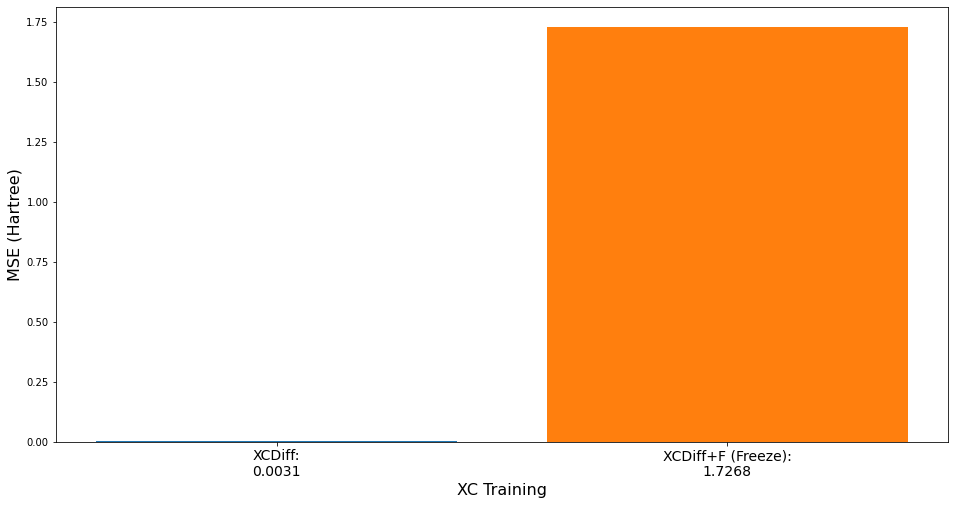

In [16]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
#'XCDiff+F:\n{:3.4f}'.format(xcdfgmse),
xtlabs = ['XCDiff:\n{:3.4f}'.format(xcdmse),'XCDiff+F (Freeze):\n{:3.4f}'.format(xcdfmse)]
ax.bar(1, xcdmse, label='XCDiff: {:3.4f}'.format(xcdmse))
ax.bar(2, xcdfmse, label='XCDiff+F {:3.4f}'.format(xcdfmse))
#ax.bar(2, xcdfgmse, label='XCDiff+F: {:3.4f}'.format(xcdfgmse))
ax.set_xticks([1,2])
ax.set_xticklabels(xtlabs, fontsize=14)
ax.set_ylabel("MSE (Hartree)", fontsize=16)
ax.set_xlabel("XC Training", fontsize=16)

<BarContainer object of 148 artists>

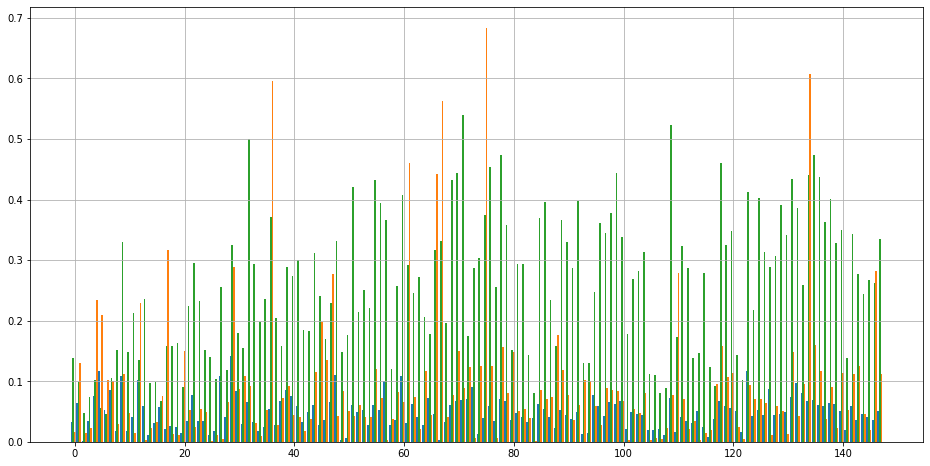

In [110]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
ax.grid()
def gen_xs_bar(*args, **kwargs):
    midsep = kwargs.get('midsep', 1)
    width = kwargs.get('width', midsep/(len(args)+2))
    xs = []
    start = -len(args)//2
    for iarg in range(len(args)):
        arg = args[iarg]
        argxs = []
        for igroup in range(len(arg)):
            argxs.append(igroup*midsep+start*width)
        start += 1
        xs.append(argxs)
    return xs
xcdx, xcdfx, xcdfgx = gen_xs_bar(xcderr, xcdferr, xcdfgerr, width=0.3)
ax.bar(xcdx, xcderr, width=0.3)
ax.bar(xcdfgx, xcdfgerr, width=0.3)
ax.bar(xcdfx, xcdferr, width=0.3)

In [100]:
xcdfgx

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0

In [4]:
xcdiffp = '/home/awills/Documents/Research/swxcd/eval/xcdiff_frac/MODEL_MGGA/xc'
model = torch.load(xcdiffp)

In [5]:
model

SCF(
  (get_veff): get_veff(
    (model): XC(
      (heg_model): LDA_X()
      (pw_model): PW_C()
      (grid_models): ModuleList(
        (0): X_L(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
            (6): Linear(in_features=16, out_features=1, bias=True)
          )
          (tanh): Tanh()
          (lobf): LOB(
            (sig): Sigmoid()
          )
        )
        (1): C_L(
          (net): Sequential(
            (0): Linear(in_features=3, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
            (6): Linear(in_features=16, out_fea

In [22]:
xcdfpg = '/home/awills/Documents/Research/swxcd/eval/xcdiff_frac/MODEL_GGA_MGGA'
parsed = pylibnxc.pyscf.utils.parse_xc_code(xcdfpg)
print(parsed)
print(pylibnxc.pyscf.utils.find_max_level(parsed))
name, mol = ase_atoms_to_mol(atoms[32])
method = pylibnxc.pyscf.RKS
mfg = KS(mol, method, model_path=xcdfpg)
mfg.grids.level = 3
mfg.density_fit()
mfg.kernel()

([0, 0, 0], [('/HOME/AWILLS/DOCUMENTS/RESEARCH/SWXCD/EVAL/XCDIFF_FRAC/MODEL_GGA_MGGA', 1)])
MGGA
TypeError:  forward() missing 1 required positional argument: 'matrices'
Trying SCF.xc.eval_grid_models
TypeError:  forward() missing 1 required positional argument: 'matrices'
Trying SCF.xc.eval_grid_models
TypeError:  forward() missing 1 required positional argument: 'matrices'
Trying SCF.xc.eval_grid_models


KeyboardInterrupt: 

In [124]:
xcdfp = '/home/awills/Documents/Research/swxcd/eval/xcdiff_frac/MODEL_MGGA'
xcdfpg = '/home/awills/Documents/Research/swxcd/eval/xcdiff_frac/MODEL_GGA_MGGA'
xcdp = '/home/awills/Documents/Research/swxcd/eval/xcdiff/MODEL_MGGA'
atoms = read('/home/awills/Documents/Research/xcdiff/data/haunschild_g2/g2_97.xyz', ':')
atoms[32]
name, mol = ase_atoms_to_mol(atoms[32])
method = pylibnxc.pyscf.RKS
mf = KS(mol, method, model_path=xcdp)
mf.grids.level = 3
mf.density_fit()
mf.kernel()

mff = KS(mol, method, model_path=xcdfp)
mff.grids.level = 3
mff.density_fit()
mff.kernel()

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/torch/serialization.py:709: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


KeyboardInterrupt: 

In [127]:
xcdm = get_scf(xctype='MGGA', path=xcdp+'/xc')
xcdm2 = torch.load(xcdp+'/xc')
xcdfmg = get_scf(xctype='GGA', path=xcdfpg+'/xc.chkpt')
xcdfm = copy.deepcopy(xcdm)
checkpt = torch.load(xcdfp+'/xc.chkpt')
freeze_append_xc(xcdfm)
xcdfm.xc.load_state_dict(torch.load(xcdfp+'/xc.chkpt'))

FREEC False
FREEC False


<All keys matched successfully>

In [129]:
xcdm2

RecursiveScriptModule(
  original_name=XC
  (heg_model): RecursiveScriptModule(original_name=LDA_X)
  (pw_model): RecursiveScriptModule(original_name=PW_C)
  (grid_models): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=XC_L
      (net): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Linear)
        (1): RecursiveScriptModule(original_name=GELU)
        (2): RecursiveScriptModule(original_name=Linear)
        (3): RecursiveScriptModule(original_name=GELU)
        (4): RecursiveScriptModule(original_name=Linear)
        (5): RecursiveScriptModule(original_name=GELU)
        (6): RecursiveScriptModule(original_name=Linear)
      )
      (tanh): RecursiveScriptModule(original_name=Tanh)
      (sig): RecursiveScriptModule(original_name=Sigmoid)
      (lobf): RecursiveScriptModule(
        original_name=LOB
        (sig): RecursiveScriptModule(original_name=Sigmoid)
      )
   

In [27]:
xcdfmg

SCF(
  (get_veff): get_veff(
    (model): XC(
      (heg_model): LDA_X()
      (pw_model): PW_C()
      (grid_models): ModuleList(
        (0): X_L(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
            (6): Linear(in_features=16, out_features=1, bias=True)
          )
          (tanh): Tanh()
          (lobf): LOB(
            (sig): Sigmoid()
          )
        )
        (1): C_L(
          (net): Sequential(
            (0): Linear(in_features=3, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
            (6): Linear(in_features=16, out_fea

In [3]:
ref = read('/home/awills/Documents/Research/swxcd/seawulf/g2_97_3/results.traj', ':')
print("XCDiff on C5H8: {}".format(mf.e_tot))
print("XCDiff+Fractional on C5H8: {}".format(mff.e_tot))
print("CCSD(T) on C5H8 : {}".format(ref[32].calc.results['energy']/Hartree))

XCDiff on C5H8: -194.9534360021965
XCDiff+Fractional on C5H8: -194.92744402878708
CCSD(T) on C5H8 : -195.01897143533844


/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [5]:
mf.make_rdm1()-mff.make_rdm1()

array([[-2.13902695e-02,  2.47839339e-04,  1.42257083e-02, ...,
        -1.67301247e-04,  7.83193179e-05, -1.93416540e-04],
       [ 2.47839339e-04,  1.52843664e-02,  1.36916009e-02, ...,
        -2.52767641e-04,  1.78066000e-04, -2.99296589e-04],
       [ 1.42257083e-02,  1.36916009e-02, -4.25327380e-02, ...,
         4.89233662e-04, -6.59716780e-04,  7.03041486e-04],
       ...,
       [-1.67301247e-04, -2.52767641e-04,  4.89233662e-04, ...,
         3.44359598e-06, -4.12836588e-06,  4.24748052e-06],
       [ 7.83193179e-05,  1.78066000e-04, -6.59716780e-04, ...,
        -4.12836588e-06, -1.10042748e-06, -5.06574695e-06],
       [-1.93416540e-04, -2.99296589e-04,  7.03041486e-04, ...,
         4.24748052e-06, -5.06574695e-06, -6.53261123e-07]])

In [ ]:
atoms = read('/home/awills/Documents/Research/xcdiff/data/haunschild_g2/g2_97.xyz', ':')
atoms[32]
name, mol = ase_atoms_to_mol(atoms[32])
mf = KS(mol, method, model_path=tp)
mf.grids.level = 3
mf.density_fit()
mf.kernel()

In [32]:
os.environ["NXC_MODELPATH"] = '/home/awills/Documents/Research/xcdiff/models/final/log_mgga_reaction2/MGGA_REACTION2'
mol = gto.M(atom='Na 0 0 0', basis='3-21G', spin=None)
method = pylibnxc.pyscf.UKS
xcp = '/home/awills/Documents/Research/swxcd/eval/xcdiff/MODEL/xc'
tp = '/home/awills/Documents/Research/xcdiff/models/final/log_mgga_reaction2/MGGA_REACTION2'
#mf = method(mol, nxc=tp, nxc_kind='grid')
model = pylibnxc.LibNXCFunctional(tp, kind='grid')
model.model_path

AttributeError: 'GridFunc' object has no attribute 'model_path'

In [8]:
mf.grids.level = 3
mf.density_fit()
mf.kernel()

PARSED:  ([0, 0, 0], [(-999, 1)])


ValueError: Model /HOME/AWILLS/DOCUMENTS/RESEARCH/XCDIFF/MODELS/FINAL/LOG_MGGA_REACTION2/MGGA_REACTION2/XC could not be found, please check name/path

In [2]:
tp = '/home/awills/Documents/Research/xcdiff/models/final/logmggareaction2/MGGA_REACTION2'
parsed = pylibnxc.pyscf.utils.parse_xc_code(tp)
print(parsed, parsed[1][0][0])
print(pylibnxc.pyscf.utils.find_max_level(parsed))

PARSED:  ([0, 0, 0], [(-999, 1)])
([0, 0, 0], [('/HOME/AWILLS/DOCUMENTS/RESEARCH/XCDIFF/MODELS/FINAL/LOGMGGAREACTION2/MGGA_REACTION2', 1)]) /HOME/AWILLS/DOCUMENTS/RESEARCH/XCDIFF/MODELS/FINAL/LOGMGGAREACTION2/MGGA_REACTION2
MGGA


In [4]:
mf.grids.level = 2
mf.kernel()

ValueError: Model GGA_X_PBE could not be found, please check name/path

In [72]:
model = get_scf(xctype='MGGA', path='/home/awills/Documents/Research/xcdiff/models/final/log_mgga_reaction2/MGGA_REACTION2/xc')

FREEC False


In [64]:
venamed = [(n,i) for n,i in model.named_parameters()]
xcnamed = [(n,i) for n,i in model.xc.named_parameters()]

In [69]:
print(venamed[0], xcnamed[0])

('get_veff.model.grid_models.0.net.0.weight', Parameter containing:
tensor([[-0.7018, -0.0108],
        [ 0.2785, -0.3875],
        [-0.0837, -0.0943],
        [ 0.6210,  0.2026],
        [-0.5129, -0.5018],
        [-0.1993,  0.3953],
        [-0.0190, -0.5222],
        [ 0.1825, -0.1985],
        [-0.6240, -0.1327],
        [ 0.3112, -0.3461],
        [-0.1302, -0.6887],
        [ 0.1273,  0.2343],
        [-0.2901,  0.6373],
        [ 0.1817,  0.0126],
        [ 0.3268, -0.0215],
        [-0.5700, -0.3154]])) ('grid_models.0.net.0.weight', Parameter containing:
tensor([[-0.7018, -0.0108],
        [ 0.2785, -0.3875],
        [-0.0837, -0.0943],
        [ 0.6210,  0.2026],
        [-0.5129, -0.5018],
        [-0.1993,  0.3953],
        [-0.0190, -0.5222],
        [ 0.1825, -0.1985],
        [-0.6240, -0.1327],
        [ 0.3112, -0.3461],
        [-0.1302, -0.6887],
        [ 0.1273,  0.2343],
        [-0.2901,  0.6373],
        [ 0.1817,  0.0126],
        [ 0.3268, -0.0215],
        [

In [103]:
freeze_net(model.xc)

In [115]:
chil = [i for i in model.xc.children() if isinstance(i, torch.nn.ModuleList)][0]
xl = [i for i in chil[0].net.children()]
cl = [i for i in chil[1].net.children()]
xout = xl.pop()
cout = cl.pop()
#duplicate last layer and GELU
xl += xl[-2:]
cl += cl[-2:]
#set last layer as unfrozen
for p in xl[-2].parameters():
    p.requires_grad = True
for p in cl[-2].parameters():
    p.requires_grad = True
xl.append(xout)
cl.append(cout)
chil[0].net = torch.nn.Sequential(*xl)
chil[1].net = torch.nn.Sequential(*cl)

In [117]:
for i in chil.parameters():
    if i.requires_grad:
        print(i)

Parameter containing:
tensor([[ 0.1118, -0.1552,  0.0532,  0.1596, -0.1311, -0.0570, -0.2327,  0.0949,
          0.1649, -0.0435, -0.0869, -0.2365, -0.0263,  0.1862,  0.1275, -0.0174],
        [ 0.0250,  0.1629,  0.1781,  0.2271,  0.0324, -0.0796, -0.1448, -0.1844,
          0.1423, -0.0355, -0.0816, -0.0059,  0.0713, -0.2077,  0.1183, -0.0579],
        [-0.1334, -0.1173, -0.0149,  0.0584, -0.2184,  0.2172,  0.0633, -0.1355,
          0.1240, -0.0776, -0.0101,  0.1160, -0.1014, -0.0462, -0.0046,  0.0255],
        [ 0.1439, -0.0159,  0.1648, -0.1594, -0.2384, -0.1637,  0.1762,  0.0836,
         -0.2010, -0.1560, -0.1395, -0.1219,  0.2044,  0.1372, -0.0689,  0.1006],
        [-0.1054, -0.0207, -0.1032,  0.0598, -0.1961, -0.1936,  0.1547,  0.2427,
         -0.2027, -0.2184, -0.1143, -0.2410, -0.0822,  0.0982, -0.0682, -0.1847],
        [-0.0438,  0.0916,  0.1053, -0.1429,  0.0448,  0.1177, -0.1364, -0.1012,
         -0.0689, -0.1839, -0.1133,  0.1002,  0.2140, -0.1638,  0.0499,  0.1990],


In [24]:
#xcdiff
fc0 = read('/home/awills/Documents/Research/swxcd/aegis/fc0/results.traj', ':')
atom_E, _, atom_mats = old_get_datapoint(fc0[0], xc='PBE')
atom_mats = {k:[v] for k,v in atom_mats.items()}
dset = Dataset(**atom_mats)
dloader = torch.utils.data.DataLoader(dset, batch_size=1)
inputs = next(iter(dloader))
model = get_scf(xctype='MGGA', path='/home/awills/Documents/Research/xcdiff/models/final/log_mgga_reaction2/MGGA_REACTION2/xc')
model.xc.train()
yhat = model(inputs[0], inputs[1], sc=False)
yhati = tuple(i for i in yhat.values())

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


Atoms(symbols='H', pbc=False, calculator=SinglePointCalculator(...))
6-311G*
Building grids...
METHOD GENERATED: <function UKS at 0x7f1a7cdf5320>
converged SCF energy = -0.499618777236592  <S^2> = 0.75  2S+1 = 2
DATAPOINT E_BASE:  -0.4996187772365916
DATAPOINT MO_ENERGY:  [[-0.27762069  0.21544503  2.07327278]
 [ 1.272361   20.68969522 63.83846139]]
DATAPOINT E_IP:  [-0.27762069]
DATAPOINT MO_OCC:  [[1. 0. 0.]
 [0. 0. 0.]]
FREEC False


/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int4c1e_sph not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)
/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/torch/serialization.py:709: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)
/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/dpyscfl/scf.py:114: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = to

In [3]:
yhati

(tensor([-0.4789], grad_fn=<CatBackward0>),
 tensor([[[0.0551, 0.1049, 0.1054],
          [0.1049, 0.1998, 0.2006],
          [0.1054, 0.2006, 0.2014]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]]], grad_fn=<StackBackward0>),
 tensor([[-0.2629,  0.2273,  2.1131],
         [ 0.0536,  0.4891,  2.5972]], grad_fn=<SymeigBackward0>))

In [4]:
make_dot(yhati, params=dict(list(model.named_parameters()))).render('model_torchviz', format='png')

'model_torchviz.png'

In [41]:
input_names = list(atom_mats.keys())
output_names = list(yhat.keys())

In [42]:
torch.onnx.export(model, (inputs,), 'model.onnx', input_names=input_names, output_names=output_names)

TypeError: train() takes 1 positional argument but 2 were given

In [47]:
model.children

<bound method Module.children of SCF(
  (get_veff): get_veff(
    (model): XC(
      (heg_model): LDA_X()
      (pw_model): PW_C()
      (grid_models): ModuleList(
        (0): X_L(
          (net): Sequential(
            (0): Linear(in_features=2, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
            (6): Linear(in_features=16, out_features=1, bias=True)
          )
          (tanh): Tanh()
          (lobf): LOB(
            (sig): Sigmoid()
          )
        )
        (1): C_L(
          (net): Sequential(
            (0): Linear(in_features=4, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
            (6

In [10]:
nel = torch.Tensor([np.nan])
bool(torch.isnan(nel))

True

In [3]:
model.

RecursiveScriptModule(
  original_name=XC
  (heg_model): RecursiveScriptModule(original_name=LDA_X)
  (pw_model): RecursiveScriptModule(original_name=PW_C)
  (grid_models): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=XC_L
      (net): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Linear)
        (1): RecursiveScriptModule(original_name=GELU)
        (2): RecursiveScriptModule(original_name=Linear)
        (3): RecursiveScriptModule(original_name=GELU)
        (4): RecursiveScriptModule(original_name=Linear)
        (5): RecursiveScriptModule(original_name=GELU)
        (6): RecursiveScriptModule(original_name=Linear)
      )
      (tanh): RecursiveScriptModule(original_name=Tanh)
      (sig): RecursiveScriptModule(original_name=Sigmoid)
      (lobf): RecursiveScriptModule(
        original_name=LOB
        (sig): RecursiveScriptModule(original_name=Sigmoid)
      )
   

In [60]:
#to generate fractional results
def mkfracdir(fs, basedir, chargedir, newdir, charge=1):
    atomsbp = read(os.path.join(basedir, 'results.traj'), ":")
    atomscp = read(os.path.join(chargedir, 'results.traj'), ':')
    for cat in atomscp:
        cat.info['charge']=charge
    basecharged = atomsbp+atomscp
    if not type(fs) == list:
        fs = [fs]
    for f in fs:
        for iat, atom in enumerate(atomsbp):
            newAtom = atom.copy()
            newAtom.calc = atom.calc
            newAtom.info['fractional'] = f
            newAtom.info['baseRef'] = basedir
            newAtom.info['chargeRef'] = chargedir
            newAtom.info['baseidx'] = iat
            basecharged.append(newAtom)
    
    try:
        os.mkdir(newdir)
    except:
        pass
    write(os.path.join(newdir, 'results.traj'), basecharged)
    idx = 0
    for iat, atom in enumerate(atomsbp):
        idx_at = '{}_{}'.format(idx, atom.get_chemical_formula())
        iat_at = '{}_{}'.format(iat, atom.get_chemical_formula())
        dmp = os.path.join(basedir, iat_at+".dm.npy")
        mocp = os.path.join(basedir, iat_at+".mo_coeff.npy")
        moop = os.path.join(basedir, iat_at+".mo_occ.npy")
        ndmp = os.path.join(newdir, idx_at+".dm.npy")
        nmocp = os.path.join(newdir, idx_at+".mo_coeff.npy")
        nmoop = os.path.join(newdir, idx_at+".mo_occ.npy")
        shutil.copy2(dmp, ndmp)
        shutil.copy2(mocp, nmocp)
        shutil.copy2(moop, nmoop)
        idx+=1
    for iat, atom in enumerate(atomscp):
        idx_at = '{}_{}'.format(idx, atom.get_chemical_formula())
        iat_at = '{}_{}'.format(iat, atom.get_chemical_formula())
        dmp = os.path.join(basedir, iat_at+".dm.npy")
        mocp = os.path.join(basedir, iat_at+".mo_coeff.npy")
        moop = os.path.join(basedir, iat_at+".mo_occ.npy")
        ndmp = os.path.join(newdir, idx_at+".dm.npy")
        nmocp = os.path.join(newdir, idx_at+".mo_coeff.npy")
        nmoop = os.path.join(newdir, idx_at+".mo_occ.npy")
        shutil.copy2(dmp, ndmp)
        shutil.copy2(mocp, nmocp)
        shutil.copy2(moop, nmoop)
        idx+=1
    

In [61]:
bdir='/home/awills/Documents/Research/swxcd/aegis/fc0'
cdir='/home/awills/Documents/Research/swxcd/aegis/fcp'
ndir='/home/awills/Documents/Research/swxcd/aegis/fc0fcp'
mkfracdir(fs=0.5, basedir=bdir, chargedir=cdir, newdir=ndir)

In [62]:
tst = read(ndir+'/results.traj', ':')

In [63]:
[i.info for i in tst]

[{'hydrogen': True},
 {'helium': True},
 {'lithium': True},
 {'beryllium': True},
 {'boron': True},
 {'carbon': True},
 {'nitrogen': True},
 {'oxygen': True},
 {'fluorine': True},
 {'neon': True},
 {'sodium': True},
 {'magnesium': True},
 {'aluminum': True},
 {'silicon': True},
 {'phosphorous': True},
 {'sulfur': True},
 {'chlorine': True},
 {'argon': True},
 {'hydrogen': True, 'charge': 1},
 {'helium': True, 'charge': 1},
 {'lithium': True, 'charge': 1},
 {'beryllium': True, 'charge': 1},
 {'boron': True, 'charge': 1},
 {'carbon': True, 'charge': 1},
 {'nitrogen': True, 'charge': 1},
 {'oxygen': True, 'charge': 1},
 {'fluorine': True, 'charge': 1},
 {'neon': True, 'charge': 1},
 {'sodium': True, 'charge': 1},
 {'magnesium': True, 'charge': 1},
 {'aluminum': True, 'charge': 1},
 {'silicon': True, 'charge': 1},
 {'phosphorous': True, 'charge': 1},
 {'sulfur': True, 'charge': 1},
 {'chlorine': True, 'charge': 1},
 {'argon': True, 'charge': 1},
 {'hydrogen': True,
  'fractional': 0.5,
  '

# General Exploration of Things

In [3]:
fc0 = read('/home/awills/Documents/Research/swxcd/aegis/fc0/results.traj', ':')
moldct = ase_traj_to_mol(fc0)
mfdct = {key:gen_mf_mol(mol, xc='SCAN', grid_level=1)[0] for key,mol in moldct.items()}
for key,mf in mfdct.items():
    print(key)
    mf.max_cycle = 500
    mf.kernel()

Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED

In [4]:
mats = [get_datapoint(moldct[key], mfdct[key], dfit=True) for key in mfdct.keys()]
mats = {key:[dct[key] for dct in mats] for key in mats[0].keys()}
E_target = torch.Tensor(mats['e_base'])

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int4c1e_sph not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)


In [8]:
dset = Dataset(**mats)
dloader = DataLoader(dset, batch_size = 1)
#inputs = next(iter(dloader)) # *
xc = XC(grid_models = [], heg_mult=True, pw_mult=True, level=1, exx_a=None)
alpha_init = 0.8
alpha = torch.nn.Parameter(torch.Tensor([alpha_init]))
#dscf = SCF(alpha=alpha, nsteps=10, xc=xc, device='cpu', exx=False)
dscf = get_scf(xctype='GGA', DEVICE='cuda')
diff = True
for name, param in dscf.named_parameters():
    param.requires_grad = diff
    print(name)
    print(param)
optimizer = torch.optim.Adam(dscf.parameters(), lr=0.01)
loss = torch.nn.MSELoss()

FREEC False
get_veff.model.grid_models.0.net.0.weight
Parameter containing:
tensor([[ 0.7129],
        [ 0.4597],
        [-0.0395],
        [ 0.8341],
        [ 0.8149],
        [ 0.7994],
        [ 0.2239],
        [ 0.8370],
        [ 0.5003],
        [-0.5867],
        [ 0.7752],
        [ 0.6802],
        [-0.2089],
        [-0.8322],
        [ 0.8005],
        [ 0.2637]], requires_grad=True)
get_veff.model.grid_models.0.net.0.bias
Parameter containing:
tensor([ 0.9437,  0.7395, -0.6417, -0.8677,  0.6172,  0.2299, -0.4634,  0.2773,
        -0.9441,  0.7391,  0.4866, -0.5730, -0.3234, -0.5353, -0.6870,  0.7592],
       requires_grad=True)
get_veff.model.grid_models.0.net.2.weight
Parameter containing:
tensor([[-6.2199e-02, -2.3068e-01,  1.2678e-01, -5.2871e-02,  2.1564e-01,
         -5.8237e-02, -7.0006e-02, -2.0120e-01, -1.7729e-01, -7.2564e-02,
          1.1545e-01,  2.1628e-01, -2.3860e-01, -1.0478e-01, -1.3672e-01,
          7.9309e-02],
        [ 1.9635e-01, -7.3907e-02,  1.40

In [7]:
dscf.named_parameters

<bound method Module.named_parameters of SCF(
  (get_veff): get_veff(
    (model): XC(
      (heg_model): LDA_X()
      (pw_model): PW_C()
      (grid_models): ModuleList(
        (0): X_L(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
            (6): Linear(in_features=16, out_features=1, bias=True)
          )
          (tanh): Tanh()
          (lobf): LOB(
            (sig): Sigmoid()
          )
        )
        (1): C_L(
          (net): Sequential(
            (0): Linear(in_features=3, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
      

In [ ]:
for step in range(10):
    print(step)
    E_pred = []
    i=0
    fails = []
    for data in dloader:
        print('MOLECULE: {}'.format(list(moldct.keys())[i]))
        try:
            output = dscf.forward(*data)
            E_pred.append(output['E'][-1])
        except RuntimeError:
            print('fail')
            fails.append(i)
        i+=1
    E_pred = torch.stack(E_pred)
    E_ref = torch.Tensor([E_target[i] for i in range(len(E_target)) if i not in fails])
    lossv = loss(E_pred, E_ref)
    print(lossv)
    print("Zeroing Gradient")
    optimizer.zero_grad()
    print("Loss Backprop")
    lossv.backward()
    print("Updating Parameters")
    optimizer.step()


0
MOLECULE: H


/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/dpyscfl/scf.py:114: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2524.)
  e, c = torch.symeig(contract('ij,...jk,kl->...il',s_chol, h, s_chol.T), eigenvectors=True,upper=False)


MOLECULE: He
fail
MOLECULE: Li
MOLECULE: Be
MOLECULE: B
MOLECULE: C
MOLECULE: N
MOLECULE: O
MOLECULE: F
MOLECULE: Ne
MOLECULE: Na
MOLECULE: Mg
MOLECULE: Al
MOLECULE: Si
MOLECULE: P
MOLECULE: S
MOLECULE: Cl
MOLECULE: Ar
tensor(0.5163, grad_fn=<MseLossBackward0>)
Zeroing Gradient
Loss Backprop
Updating Parameters
1
MOLECULE: H
MOLECULE: He
fail
MOLECULE: Li
MOLECULE: Be
MOLECULE: B
MOLECULE: C
MOLECULE: N
MOLECULE: O
MOLECULE: F
MOLECULE: Ne
MOLECULE: Na
MOLECULE: Mg
MOLECULE: Al
MOLECULE: Si
MOLECULE: P
MOLECULE: S
MOLECULE: Cl
MOLECULE: Ar
tensor(0.5163, grad_fn=<MseLossBackward0>)
Zeroing Gradient
Loss Backprop
Updating Parameters
2
MOLECULE: H
MOLECULE: He
fail
MOLECULE: Li
MOLECULE: Be


In [63]:
dscf.parameters

<bound method Module.parameters of SCF(
  (get_veff): get_veff(
    (model): XC(
      (heg_model): LDA_X()
      (pw_model): PW_C()
    )
  )
  (eig): eig()
  (energy_tot): energy_tot()
  (make_rdm1): make_rdm1()
  (xc): XC(
    (heg_model): LDA_X()
    (pw_model): PW_C()
  )
)>

In [44]:
torch.stack(E_pred)

tensor([-4.7855e-01, -7.3415e+00, -1.4444e+01, -2.4351e+01, -5.4069e+01,
        -9.9096e+01, -1.2821e+02, -1.6143e+02, -1.9912e+02, -2.4131e+02,
        -3.3996e+02, -5.2592e+02], grad_fn=<StackBackward0>)

In [41]:
fails

[1, 5, 7, 13, 15, 16]

In [7]:
traj = read('/home/awills/Documents/Research/xcdiff/data/haunschild_pbe.traj', ':')

In [3]:
[(i.get_chemical_formula(), i.info) for i in traj]
mols = [gto.M(atom=[[ispec,ipos] for ispec,ipos in zip(iat.get_chemical_formula(), iat.positions)], spin=None, charge=0) for iat in traj[:2]]

In [4]:
mols[0].spin

1

# KSPies for Wu-Yang Decomposition, Fractional Charge Generation

In [9]:
mol = gto.M(atom='Na 0 0 0', basis='3-21G', spin=None)
molp = gto.M(atom='Na 0 0 0', basis='3-21G', charge=1, spin=None)
molh = gto.M(atom='Na 0 0 0', basis='3-21G', charge=0.5, spin=None)
mf = scf.UHF(mol)
mfp = scf.UHF(molp)
print(mf, mfp)
mf.kernel()
mfp.kernel()
e0 = mf.energy_tot()
ep = mfp.energy_tot()
dm = mf.make_rdm1()
dmp = mfp.make_rdm1()
print(dm.shape, dmp.shape)
wy0 = wy.UWY(mol, dm)
wyp = wy.UWY(molp, dmp)
wy0.wyscf()
wyp.wyscf()
wyh = wy.UWY(mol, (1-0.5)*dm+0.5*dmp )
wyh.wyscf()
wyh.info()



WARN: Found fractional number of electrons 10.500000. Round it to 10

<pyscf.scf.uhf.UHF object at 0x7f315337b290> <pyscf.scf.uhf.UHF object at 0x7f32787a73d0>
converged SCF energy = -160.854064685781  <S^2> = 0.75003623  2S+1 = 2.0000362
converged SCF energy = -160.6737462472  <S^2> = 4.4408921e-15  2S+1 = 1
(2, 13, 13) (2, 13, 13)
 *****Optimization Failed*****
      after 59 iterations 
func_value :   -160.26916001
max_grad   :      0.01322541


In [12]:
print("Baseline DM - f=0.5 DM")
print("C=0 - C=1: ", np.sum(abs(dm-dmp)))
print("C=0 - C=0.5: ", np.sum(abs(dm-wyh.dm)))
print("C=1 - C=0.5: ",np.sum(abs(dmp-wyh.dm)))
print("Baseline - WY f=0/1 DM")
print("C=1 - WY=1: ", np.sum(abs(dmp-wyp.dm)))
print("C=0 - WY=0: ", np.sum(abs(dmp-wy0.dm)))

Baseline DM - f=0.5 DM
C=0 - C=1:  1.7648032106072404
C=0 - C=0.5:  11.494551069412225
C=1 - C=0.5:  9.882080937161142
Baseline - WY f=0/1 DM
C=1 - WY=1:  0.040290751956452
C=0 - WY=0:  1.7349746992771082


In [13]:
print(wyh.mo_occ)
print(wyp.mo_occ)
print(wy0.mo_occ)

[[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [16]:
print(wyh.mo_coeff.shape)

(2, 13, 13)


In [26]:
ind = np.where(wyh.mo_occ[0]-wyh.mo_occ[1])
wyh.mo_occ[1, ind] = 0.5
wyh.mo_occ
wyh.wyscf()
mol.intor??

In [4]:
print(mol.intor('int1e_kin').sum())
print(molp.intor('int1e_kin').sum())

74.7851944955926
74.7851944955926


In [7]:
mf.mo_occ, mfp.mo_occ, wyh.mo_occ

(array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [31]:
mf.mo_energy.shape, mfp.mo_energy.shape

((2, 13), (13,))

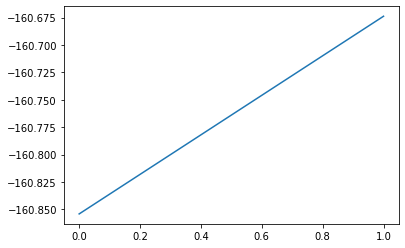

In [9]:
def fractional_energy(e0, ec, f, zero=False):
    return (1-f)*e0 + f*ec
def fractional_dm(dm0, dmc, f):
    return (1-f)*dm0 + f*dmc
f = plt.figure()
ax = f.add_subplot(111)
fs = np.linspace(0, 1, 100)
ax.plot(fs, fractional_energy(e0, ep, fs))

In [52]:
wyh = wy.UWY(mol, 0.5*dm+0.5*dmp)
wyh.wyscf()
wyh.info()

****Optimization Completed****
      after 3 scf cycles 
      and 8 iterations 
max(ddm)   :      0.00000095
func_value :   -160.26527030
max_grad   :      0.00000039


### 1. Define the xc model

Here we use a simple LDA model (`level = 1`), by choosing `heg_mult = True` (for homogeneous electron gas exchange) and `pw_mult = True` (for Perdew Wang HEG correlation), without any enhancement factors (`grid_models = []`). No Hartree-Fock exact exchange is used `exx_a=None`.

In [2]:
#c = C_L(n_input=3) #3 for gga
#x = X_L(n_input=3) #3 for GGA

#xc = XC(grid_models = [c], heg_mult=False, pw_mult=False, level=2, exx_a=1)
#xc = XC(grid_models = [x], heg_mult=False, pw_mult=False, level=2, exx_a=None)

#xc = XC(grid_models = [x,c], heg_mult=False, pw_mult=False, level=2, exx_a=None)

xc = XC(grid_models = [], heg_mult=True, pw_mult=True, level=1, exx_a=None)

Create the object that runs the SCF calculation

In [3]:
alpha_init = 0.8
alpha = torch.nn.Parameter(torch.Tensor([alpha_init]))
dscf = SCF(alpha=alpha, nsteps=10, xc=xc, device='cpu', exx=False)

### 2. Create a molecule with pyscf

This computes all overlap integrals and other information that will be used by our differentiable implementation

In [4]:
mol2 = gto.M(atom='H 0 0 0', basis='3-21G', spin=None)
mol = gto.M(atom='H 0 0 0; H 0 0 1', basis='3-21G')
mf = scf.RKS(mol)
mf.grids.level = 1
mf.grids.build()
mf.kernel()
E_converged = mf.e_tot

converged SCF energy = -1.1074945503839


### 3. Create input data structures

In [5]:
# * The marked lines are just workarounds because we are only dealing with one system in this tutorial and both Dataset and DataLoader are designed 
# to deal with multiple data points 

matrices = get_datapoint(mol, mf)
matrices = {key: [val] for key,val in matrices.items()} # *
dset = Dataset(**matrices)
dloader = DataLoader(dset, batch_size = 1)
inputs = next(iter(dloader)) # *

DATAPOINT E_BASE:  -1.1074945503839038
DATAPOINT MO_ENERGY:  [-0.33172767  0.01634343  0.81367669  0.99496847]
DATAPOINT E_IP:  [-0.33172767]
DATAPOINT MO_OCC:  [2. 0. 0. 0.]


/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int4c1e_sph not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)


### 4. Run the calculation

In [52]:
output = dscf.forward(*inputs)

In [37]:
output

{'E': tensor([-0.1824, -0.4248, -0.4077, -0.4072, -0.4071, -0.4071, -0.4071, -0.4071,
         -0.4071, -0.4071], grad_fn=<CatBackward0>),
 'dm': tensor([[0.0608, 0.1484, 0.0608, 0.1484],
         [0.1484, 0.3623, 0.1484, 0.3623],
         [0.0608, 0.1484, 0.0608, 0.1484],
         [0.1484, 0.3623, 0.1484, 0.3623]], grad_fn=<PermuteBackward0>),
 'mo_energy': tensor([0.0613, 0.3411, 1.1934, 1.4133], grad_fn=<SymeigBackward0>)}

## 5. Calculate the loss

In [38]:
E_converged_t = torch.Tensor([E_converged])

E_converged_t

tensor([-1.1075])

Mean squared error loss:

In [39]:
torch.sum((output['E'] - E_converged_t)**2)

tensor(5.2453, grad_fn=<SumBackward0>)

PyTorch-native MSE loss 

In [40]:
loss = torch.nn.MSELoss()
loss_value = loss(output['E'], E_converged_t.repeat(10))
loss_value

tensor(0.5245, grad_fn=<MseLossBackward0>)

Calculate gradients with backprop

In [41]:
loss_value.backward()

In [42]:
alpha.grad

tensor([-0.0233])

Optimizer

In [43]:
opt = torch.optim.SGD([alpha], lr=0.001)
opt.step()

In [44]:
print('Old alpha:', alpha_init)
print('New alpha:', alpha.detach().numpy()[0])

Old alpha: 0.8
New alpha: 0.8000232706344446


In [58]:
loss = torch.nn.MSELoss()
opt = torch.optim.SGD([alpha], lr=0.001)

for i in range(50):
    print(i)
    ioutput = dscf.forward(*inputs)
    loss_value = loss(ioutput['E'], E_converged_t.repeat(10))
    loss_value.backward()
    opt.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [59]:
print(alpha_init, alpha)

0.8 Parameter containing:
tensor([0.8672], requires_grad=True)


In [60]:
loss_value

tensor(0.5233, grad_fn=<MseLossBackward0>)